In [6]:
# !pip install pandas-datareader
# !pip install yfinance
# !pip install quandl

In [9]:
import numpy as np
import yfinance as yf
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

#from pandas_datareader import data as wb

#import quandl

The company we will use for our analysis will be Apple. 
The timeframe under consideration reflects the past 17 years, 
starting from January the 1st 2007.

In [10]:
ticker = 'AAPL'
data = yf.download(ticker, start='2007-01-01')['Close']
print(data.head())  

#Why Use Adjusted Prices Instead of Raw Closing Prices?
#For financial calculations such as returns, volatility, or trend analysis, 
#the adjusted prices ensure accuracy by normalizing the data. 
#Without this, the raw closing price (Close) may show artificial jumps or drops 
#that don’t represent actual market behavior.



[*********************100%***********************]  1 of 1 completed

Ticker          AAPL
Date                
2007-01-03  2.524617
2007-01-04  2.580652
2007-01-05  2.562275
2007-01-08  2.574928
2007-01-09  2.788827


In [14]:
def monte_carlo_simulation(data, testsize = 0.4, simulation = 1000, training_horizon = 100, testing_horizon = 50):
    #step 1: train test data set split
    data = np.array(data)
    train_size = int(len(data)*(1-testsize))
    train_data = data[:train_size]
    test_data = data[train_size:]

    #step 2: log returns calculation
    pct_changes = (train_data[1:] - train_data[:-1]) / train_data[:-1]  # Element-wise percentage change
    log_returns = np.log(1 + pct_changes)


    #step 3: Calculate drift(mu) and volatility(sigma or standard deviation)
    mu = log_returns.mean()
    sigma = log_returns.std()

    #step 4: store predictions
    simulations = {}

    #step 5: perform simulations
    for i in range(simulation):
        S_0 = train_data[-1] #last price in training set
        simulated_prices = [S_0]

        for t in range(training_horizon+testing_horizon):
            #geometric brownian motion
            Z_t = norm.rvs()
            next_price = simulated_prices[-1] * np.exp((mu - 0.5 * sigma**2)+ sigma*Z_t)
            simulated_prices.append(next_price)

        simulations[i] = simulated_prices

    
    #step 6: calculate std dev of each simulation and compare with actual data
    min_std_dev = float('inf')
    best_simulation = None

    for sim_key, sim_values in simulations.items():
        #compare forecast with actual test data
        forecast = np.array(sim_values[training_horizon+1:])
        actual = np.array(test_data[:testing_horizon])

        #compute std dev
        std_dev = np.std(forecast - actual)

        if std_dev < min_std_dev:
            min_std_dev = std_dev
            best_simulation = sim_key
    return simulations[best_simulation], min_std_dev


    

In [15]:
best_simulation_data, min_std_dev = monte_carlo_simulation(data)

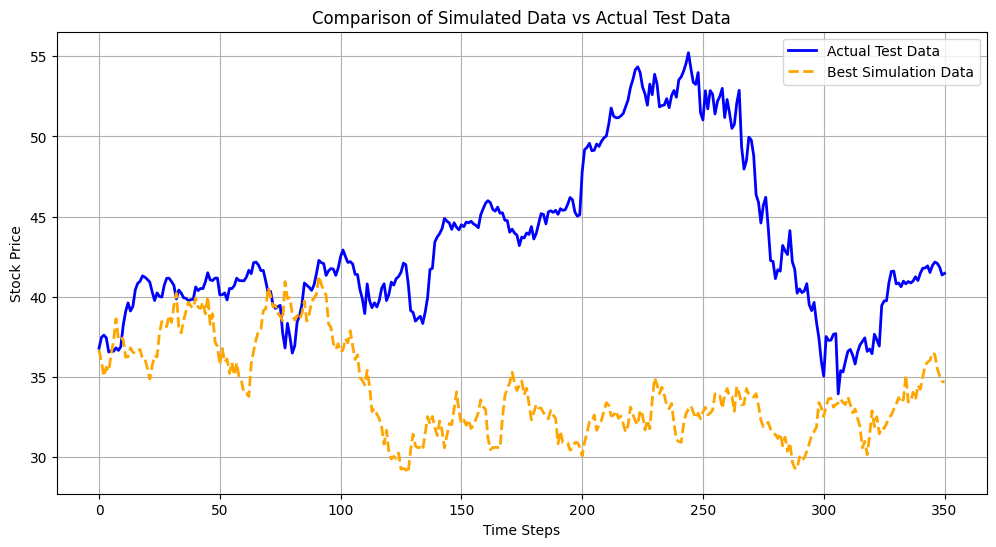

In [16]:
# Extract the portion of test data for the comparison
test_size = int(len(data) * 0.4)
test_data = data[-test_size:]  # Last 40% of the data

# Align the lengths of simulated data and actual test data
testing_horizon = len(best_simulation_data)  # Use the length of the best simulation data
actual_test_data = test_data[:testing_horizon]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_test_data)), actual_test_data, label="Actual Test Data", color='blue', linewidth=2)
plt.plot(range(len(best_simulation_data)), best_simulation_data, label="Best Simulation Data", color='orange', linestyle='--', linewidth=2)

# Add labels, title, and legend
plt.title("Comparison of Simulated Data vs Actual Test Data")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


We want to forecast P&G’s future stock price in this exercise. 
So, the first thing we’ll do is estimate its historical log returns. 
The method we’ll apply here is called “percent change”, 
and you must write “pct_change()” to obtain the simple returns 
from a provided dataset. We can create the formula for log returns 
by using NumPy’s log and then type 1 + the simple returns extracted 
from our data. 

In [ ]:
log_returns = np.log(1+data.pct_change())
log_returns.tail()

In [ ]:
data.plot(figsize = (10,6))

In the first graph, we can see P&G’s price, 
which has been gradually growing during the past decade.

In [ ]:
log_returns.plot(figsize = (10,6))

In the second one, we plot the log returns, not the price, of P&G. 
The picture tells us the returns are normally distributed 
and have a stable mean. Great!

Now, let’s explore their mean and variance, as we will need them for the calculation of the Brownian motion.

In [ ]:
u = log_returns.mean()
var = log_returns.var()
u

In [ ]:
var

Firstly, let's compute the drift component. It is the best approximation of future rates of return of the stock. The formula to use here will be “U”, which equals the average log return, minus half its variance.

In [ ]:
drift = u - 0.5*var

Next, we will create a variable, called “stdev”, and we will assign to it the standard deviation of log returns. We said the Brownian motion comprises the sum of the drift and a variance adjusted by “E” to the power of “R”, so we will use this block in the second part of the expression.\
r = drift + stdev * (e^r)

In [ ]:
stdev = log_returns.std()
stdev

In [ ]:
type(drift)

In [ ]:
type(stdev)

In [ ]:
np.array(drift)

In [ ]:
stdev.values

The second component of the Brownian motion is a random variable, z, a number corresponding to the distance between the mean and the events, expressed as the number of standard deviations.

SciPy’s norm dot “PPF” allows us to obtain this result.

In [ ]:
norm.ppf(0.95)

If an event has a 95% chance of occurring, the distance between this event and the mean will be approximately 1.65 standard deviations, ok? This is how it works.

To complete the second component, we will need to randomize. The well-known NumPy “rand” function can help us do that easily. If we want to create a multi-dimensional array, we will need to insert two arguments. So, I’ll type 10 and 2.

In [ ]:
x = np.random.rand(10, 2)
x

In [ ]:
norm.ppf(x)

So, once we have built these tools and calculated all necessary variables, we are ready to calculate daily returns. All the infrastructure is in place.
Ok. So, first, I would like to specify the time intervals we will use will be 1,000, because we are interested in forecasting the stock price for the upcoming 1,000 days. Then, to “iterations” I will attribute the value of 10, which means I will ask the computer to produce 10 series of future stock price predictions.

In [ ]:
t_intervals = 1000
iterations = 10
daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations)))

The variable “daily returns” will show us what will equal “E” to the power of “R”. We will need NumPy’s “EXP” function, which means we are calculating Euler’s number “E” raised to the power of the expression written between the parentheses.\
In the parentheses, we will have the value of the drift and the product of the standard deviation and the random component, created with the help of the “norm” module. Its percentage value was generated with NumPy’s “rand” function, using “time intervals” and “iterations” specifying the dimensions of the array filled with values from 0 to 1.



In [ ]:
daily_returns

Great!
So, the formula we used in the previous cell would allow us to obtain a 1,000 by 10 array with daily return values – 10 sets of 1,000 random future stock prices.

We are a single step away from completing this. All we have to do is create a price list. Each price must equal the product of the price observed the previous day and the simulated daily return. Therefore, once we obtain the price in day T, we can estimate the expected stock price we will have in day T plus 1.\
$S_{t+1} = S_t \times \text{daily\_return}_t$


In [ ]:
S0 = data.iloc[-1]
S0

In [ ]:
price_list = np.zeros_like(daily_returns)
price_list

Well, now we can replace these zeros with the expected stock prices by using a loop.
Let’s do this!
First, we must set the first row of our price list to “S zero”.

In [ ]:
price_list[0]

Yes, not just the first value, but the entire row of 10 elements, because “S zero” will be the initial price for each of the 10 iterations we intend to generate. We will obtain the following array.

In [ ]:
price_list[0] = S0
price_list

Finally, we can generate values for our price list. We must set up a loop that begins in day 1 and ends at day 1,000. We can simply write down the formula for the expected stock price on day T in Pythonic. It will be equal to the price in day T minus 1, times the daily return observed in day T.

In [ ]:
for t in range(1, t_intervals):
    price_list[t] = price_list[t-1] * daily_returns[t-1]
price_list

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(price_list);

In [ ]:
testsize = 0.4
train_size = int(len(data)*(1-testsize))
train_size

In [ ]:
train_data = data[:train_size]
t = train_data.iloc[-1]
t['PG']

In [ ]:
data = np.array(data)
data